In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Зададим нужные константы для обучения:

In [2]:
# we perform T*Q-fold cross validation (T*Q-fold CV)
T = 3  # number of performing cross validations
Q = 5  # number of folds
SCORING = 'accuracy'

Загрузим подготовленные данные:

In [2]:
from sklearn.externals import joblib

X_train = joblib.load('../data/X_train.pkl')
y_train = joblib.load('../data/y_train.pkl')

# X_train = joblib.load('../tmp/1467_X_train.pkl')
# y_train = joblib.load('../tmp/1467_y_train.pkl')

display(X_train)

,DIRECTORY_ENTRY_BOUND_IMPORT/exists,DIRECTORY_ENTRY_DEBUG/exists,DIRECTORY_ENTRY_DELAY_IMPORT/exists,DIRECTORY_ENTRY_EXPORT/exists,DIRECTORY_ENTRY_IMPORT/exists,DIRECTORY_ENTRY_RESOURCE/exists,DIRECTORY_ENTRY_TLS/exists,DOSStub/entropy,DOSStub/zeros,DOS_HEADER.e_cblp,...,SECTIONS/entry_point_in_last_section,SECTIONS/entry_point_in_writeable_section,SECTIONS/executable_sections,SECTIONS/max_section_entropy,SECTIONS/rsrc_section_entropy,SECTIONS/sections_with_zero_entropy_count,SECTIONS/text_section_entropy,SECTIONS/unusual_section_names,SECTIONS/writeable_and_executable_sections,SECTIONS/writeable_sections
26682,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,0.333973,-0.507212,0.569661,-0.572900,-0.011388,...,-0.227519,-0.452174,-0.269120,-0.377887,0.548801,0.258948,0.546524,-0.460900,-0.288560,-0.094187
50916,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,0.333973,-0.507212,0.373237,-0.234648,-0.011388,...,-0.227519,-0.452174,-0.269120,-0.444852,0.051442,0.258948,0.525452,-0.460900,-0.288560,-0.094187
29258,-0.145786,-0.079078,-0.150130,-0.304439,-0.078087,0.333973,-0.507212,0.333303,-0.542699,-0.011388,...,-0.227519,-0.452174,-0.269120,-0.268217,-0.186286,-0.665014,0.581034,-0.460900,-0.288560,-0.094187
18211,-0.145786,0.129710,1.233757,-0.304439,0.712365,0.333973,-0.507212,0.630445,-0.682722,-0.011388,...,-0.227519,-0.452174,-0.269120,-0.252136,0.204942,-0.665014,0.586095,-0.460900,-0.288560,-0.655287
31183,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,0.333973,-0.507212,0.467182,-0.191413,-0.011388,...,-0.227519,-0.452174,-0.269120,-0.383324,0.548744,0.258948,0.544813,-0.460900,-0.288560,-0.094187
54395,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,-2.994258,-0.507212,0.333303,-0.542699,-0.011388,...,4.395228,-0.452174,0.569053,0.459248,-2.024843,0.258948,0.809948,0.131280,0.518246,1.028014
27351,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,0.333973,-0.507212,0.421855,-0.309327,-0.011388,...,-0.227519,-0.452174,-0.269120,-0.335065,0.369694,0.258948,0.559999,-0.460900,-0.288560,-0.094187
27791,-0.145786,-0.079078,8.845135,3.284733,1.601623,0.333973,1.971561,-1.770532,1.874648,-0.102259,...,-0.227519,-0.452174,0.569053,0.242980,1.187646,1.182910,0.534680,-0.460900,-0.288560,1.589115
19336,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,0.333973,-0.507212,0.629202,-0.599746,-0.011388,...,-0.227519,-0.452174,-0.269120,1.378243,0.986296,0.258948,0.562126,-0.460900,-0.288560,-0.094187
27617,-0.145786,0.547286,-0.150130,-0.304439,-0.374507,0.333973,-0.507212,0.611762,-0.664942,-0.011388,...,-0.227519,-0.452174,-0.269120,-1.062610,-0.885523,-0.665014,0.331061,-0.460900,-0.288560,-0.655287


In [4]:
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix


def test_classifier(classifier, X, y):
    tns, fps, fns, tps = ([], [], [], [])

    rkf = RepeatedKFold(n_splits=Q, n_repeats=T, random_state=398)
    for train_index, test_index in rkf.split(X):
        curr_X_train, curr_X_test = X.iloc[train_index], X.iloc[test_index]
        curr_y_train, curr_y_test = y.iloc[train_index], y.iloc[test_index]
        classifier.fit(curr_X_train, curr_y_train)
        curr_y_pred = classifier.predict(curr_X_test)
        curr_tn, curr_fp, curr_fn, curr_tp = (
            confusion_matrix(curr_y_test, curr_y_pred).ravel()
        )

        curr_test_size = curr_tn + curr_fp + curr_fn + curr_tp
        assert(curr_test_size == len(curr_X_test)
                   and curr_test_size == len(curr_y_test))
        tns.append({
            'tn': curr_tn,
            'test_size': curr_test_size,
            'tn_rate': curr_tn/curr_test_size,
        })
        fps.append({
            'fp': curr_fp,
            'test_size': curr_test_size,
            'fp_rate': curr_fp/curr_test_size,
        })
        fns.append({
            'fn': curr_fn,
            'test_size': curr_test_size,
            'fn_rate': curr_fn/curr_test_size,
        })
        tps.append({
            'tp': curr_tp,
            'test_size': curr_test_size,
            'tp_rate': curr_tp/curr_test_size,
        })

    tns_df = pd.DataFrame(tns)
    fps_df = pd.DataFrame(fps)
    fns_df = pd.DataFrame(fns)
    tps_df = pd.DataFrame(tps)
    return (tns_df, fps_df, fns_df, tps_df)

In [28]:
def make_plot(accuracies, deviations, max_depth, estimators_numbers):
    assert(len(accuracies) == len(deviations))
    plt.figure(figsize=(20, 12))
    
    upper = []
    lower = []
    for i in range(len(accuracies)):
        upper.append(accuracies[i] + deviations[i])
        lower.append(accuracies[i] - deviations[i])
    plt.fill_between(
        estimators_numbers,
        upper,
        lower,
        alpha=0.2,
        color='steelblue',
        lw=1
    )
    
    # plt.grid(True)
    plt.xscale('log')
    plt.ylim([0.75, 1.00])
    plt.xlabel('Число деревьев', fontsize=40)
    plt.ylabel('accuracy', fontsize=40)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=40)
    ax.tick_params(axis='both', which='minor', labelsize=40)
    plt.plot(estimators_numbers, accuracies, color='blue', marker='o')
    plt.savefig(
        '../results/boosting/{0}.svg'.format(max_depth),
        format='svg',
        dpi=72
    )

estimators_number = 50 ; accuracy = 0.7849770780447082
estimators_number = 100 ; accuracy = 0.8034767899168938
estimators_number = 250 ; accuracy = 0.8323507110229477
estimators_number = 500 ; accuracy = 0.8420941947418181
estimators_number = 1000 ; accuracy = 0.8508321831343171
estimators_number = 2500 ; accuracy = 0.8723573542360941
estimators_number = 5000 ; accuracy = 0.8836911611214423
estimators_number = 10000 ; accuracy = 0.8892301355889478
estimators_number = 15000 ; accuracy = 0.8921824314959689
estimators_number = 20000 ; accuracy = 0.895015883217306
estimators_number = 25000 ; accuracy = 0.8971729561319715
best_accuracy = 0.897172956132


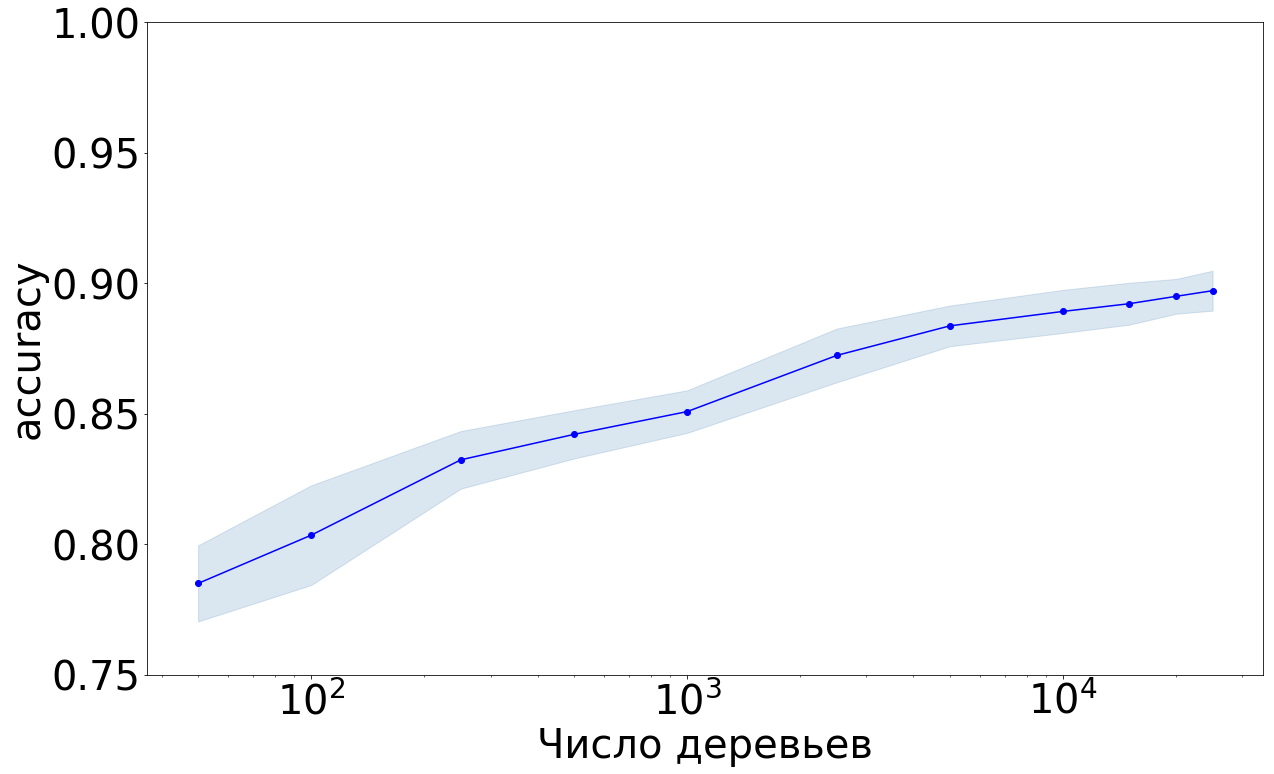

In [29]:
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier


def boost():
    estimators_numbers = (
        50, 100, 250, 500, 1000, 2500, 5000, 10000, 15000, 20000, 25000
    )
    best_accuracy = 0.0
    accuracies = []
    deviations = []
    for curr_estimators_number in estimators_numbers:
        curr_boost_classifier = AdaBoostClassifier(
            n_estimators=curr_estimators_number,
            algorithm='SAMME'
        )
        curr_tns_df, curr_fps_df, curr_fns_df, curr_tps_df = (
            test_classifier(curr_boost_classifier, X_train, y_train)
        )

        curr_accuracies = []
        for i in range(T*Q):
            curr_tn_rate = curr_tns_df.at[i, 'tn_rate']
            curr_fp_rate = curr_fps_df.at[i, 'fp_rate']
            curr_fn_rate = curr_fns_df.at[i, 'fn_rate']
            curr_tp_rate = curr_tps_df.at[i, 'tp_rate']
            curr_accuracies.append(
                (curr_tp_rate + curr_tn_rate)/
                (curr_tp_rate + curr_tn_rate + curr_fp_rate + curr_fn_rate)
            )
        curr_avg_accuracy = sum(curr_accuracies)/len(curr_accuracies)
        accuracies.append(curr_avg_accuracy)
        deviations.append(np.array(curr_accuracies).std()*2)

        print(
            'estimators_number = {0} ; accuracy = {1}'.format(
            curr_estimators_number, curr_avg_accuracy)
        )
        if curr_avg_accuracy > best_accuracy:
            best_accuracy = curr_avg_accuracy

    make_plot(accuracies, deviations, 'adaboost', estimators_numbers)
                
    print('================================')
    print('best_accuracy =', best_accuracy)



boost()

In [1]:
# boosted_classifier = GradientBoostingClassifier(
#     loss='exponential',
#     max_depth=10,
#     n_estimators=5000,
#     # silent=False,
#     max_features=None
# )

# boosted_classifier.fit(X_train, y_train)
# y_pred = boosted_classifier.predict(X_test)
# test_tn, test_fp, test_fn, test_tp = (
#     confusion_matrix(y_test, y_pred).ravel()
# )

# print('TEST accuracy =', (test_tp + test_tn)/len(y_pred))
# print('TEST tn rate =', test_tn/len(y_pred))
# print('TEST fp rate =', test_fp/len(y_pred))
# print('TEST fn rate =', test_fn/len(y_pred))
# print('TEST tp rate =', test_tp/len(y_pred))

### К этому моменту мы настроили гиперпараметры!

Теперь нужно указать подобранные гиперпараметры в качестве следующих констант:
* BEST_ESTIMATORS_N --- количество деревьев в бустинге на деревьях
* BEST_MAX_DEPTH    --- максимальная глубина одного дерева

In [3]:
BEST_ESTIMATORS_N = 5000
BEST_MAX_DEPTH = 15

Создадим объект классификатора с настроенными гиперпараметрами:

In [4]:
from sklearn.ensemble import GradientBoostingClassifier

boost_classifier = GradientBoostingClassifier(
    loss='exponential',
    max_depth=BEST_MAX_DEPTH,
    n_estimators=BEST_ESTIMATORS_N,
    max_features=None
)

Обучим классификатор на обучающей выборке (X_train, y_train):

In [7]:
boost_classifier.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=15,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### На данном этапе процесс обучения завершён!

Сохраним классификатор на диск.

In [8]:
from sklearn.externals import joblib
joblib.dump(boost_classifier, '../results/boosting/boosting_classifier.pkl')

['../results/boosting/boosting_classifier.pkl']